- Correlation matrix between covariates and returns
- Visualize the returns dynamics
- Analyze trends and seasonality
- ACF and PACF
- Adding lags for looking for correlation between returns and past returns

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import yfinance as yf
from scipy.stats import norm
from statsmodels.tsa.arima.model import ARIMA

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# FOR ALL TICKERS EXCEPT FOR ABBV

In [3]:
os.chdir('/content/drive/My Drive/thesis/final_submission')
df = pd.read_csv('non_nan_4.csv')

In [4]:
df

,Date,unemployment_rate,CPI,treasury_yield,GDP_growth,SP500_return,AZN,BMY,JNJ,LLY,MRK,NVO,NVS,PFE,ROG,inflation_change,unemp_change,treasury_yield_change
0,2000-02-01,4.1,170.000,6.661000,0.496560,-1.522563,-12.828964,-13.228004,-16.339821,-11.121498,-21.701151,2.220031,3.838386,-11.226228,54.440789,1.000,-0.1,-0.141500
1,2000-03-01,4.0,171.000,6.519500,0.511258,9.413333,22.264136,-0.218329,-2.079067,5.804243,0.913712,8.390897,6.420237,14.101954,6.922258,1.000,-0.1,-0.141500
2,2000-04-01,3.8,170.900,6.256522,1.327803,-3.266805,5.567379,-8.205683,17.437698,23.153694,12.400712,-0.097663,2.559423,15.213674,7.370518,-0.100,-0.2,-0.262978
3,2000-05-01,4.0,171.200,5.990526,-0.181797,-1.572223,-0.148357,5.395746,8.484832,-1.296597,7.374072,20.863985,5.169310,5.638019,-8.163265,0.300,0.2,-0.265995
4,2000-06-01,4.0,172.200,6.440455,0.305565,1.728613,10.549735,5.788826,14.239888,31.641749,3.078671,2.813690,8.474599,8.076012,13.131313,1.000,0.0,0.449928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,2023-01-01,3.4,300.536,3.616190,0.390254,6.776820,-3.584079,0.972908,-7.489384,-5.928822,-2.549213,2.541749,-0.110227,-13.817335,16.968326,1.546,-0.1,-0.274810
276,2023-02-01,3.6,301.648,3.531500,-0.442183,-2.514271,-0.290649,-4.328217,-6.217115,-9.568502,-1.089288,1.592445,-7.172811,-7.286115,5.451681,1.112,0.2,-0.084690
277,2023-03-01,3.5,301.808,3.746842,-0.442183,3.313488,8.035329,0.507544,1.862736,10.703390,0.141189,12.873250,9.367574,0.566924,11.025813,0.160,-0.1,0.215342
278,2023-04-01,3.4,302.918,3.663043,-0.442183,1.985238,5.489119,-3.664707,5.612908,15.269915,9.289214,5.836894,16.334413,-4.681371,-1.517467,1.110,-0.1,-0.083799


In [5]:
def create_lags_cov(data, covs, period):
    lagged_covs = []  # List to store the names of lagged columns

    for covariate in covs:
        for i in period:
            lagged_column_name = f'{covariate}_lag{i}'
            data[lagged_column_name] = data[covariate].shift(i)
            lagged_covs.append(lagged_column_name)

    data.dropna(inplace=True)
    data = data.reset_index(drop=True)

    return data, lagged_covs

In [6]:
def create_lags_returns(data, tickers, period):

    lagged_tickers = []  # List to store the names of lagged columns

    for tick in tickers:
        for i in period:
            lagged_column_name = f'{tick}_lag{i}'
            data[lagged_column_name] = data[tick].shift(i)
            lagged_tickers.append(lagged_column_name)

    data.dropna(inplace=True)
    data = data.reset_index(drop=True)

    return data, lagged_tickers

In [7]:
# Creating lagged variables
tickers = ['AZN', 'BMY', 'JNJ', 'LLY', 'MRK', 'NVO', 'NVS', 'PFE','ROG']
covs = ['unemployment_rate', 'CPI', 'treasury_yield', 'GDP_growth', 'SP500_return', 'inflation_change', 'unemp_change', 'treasury_yield_change']
period_covs = [1, 2, 3]
period_returns = [1,2]

data, lagged_covs = create_lags_cov(df, covs, period=period_covs)
data, lagged_tickers = create_lags_returns(df, tickers, period= period_returns)

In [8]:
# Creating dummy variables
data['Quater_dummy'] = 0
data['Quater_rippel'] = 0
data['Date'] = pd.to_datetime(data['Date'])
for index, row in data.iterrows():
    if row['Date'].month in [3, 6, 9, 12]:
        data.loc[index, 'Quater_dummy'] = 1
    if row['Date'].month in [1, 4, 7, 10]:
        data.loc[index, 'Quater_dummy'] = 1

In [9]:
data

,Date,unemployment_rate,CPI,treasury_yield,GDP_growth,SP500_return,AZN,BMY,JNJ,LLY,...,NVO_lag1,NVO_lag2,NVS_lag1,NVS_lag2,PFE_lag1,PFE_lag2,ROG_lag1,ROG_lag2,Quater_dummy,Quater_rippel
0,2000-07-01,4.0,172.700,6.097273,-0.653855,-1.338453,-8.064479,-11.373392,-8.650271,4.005041,...,2.813690,20.863985,8.474599,5.169310,8.076012,5.638019,13.131313,-8.163265,1,0
1,2000-08-01,4.1,172.700,6.054000,0.795710,6.534124,6.578935,3.131245,-1.192113,-29.708189,...,13.757382,2.813690,-3.593737,8.474599,-9.635421,8.076012,2.142857,13.131313,0,0
2,2000-09-01,3.9,173.600,5.826087,0.249670,-5.723123,15.363525,8.458631,2.496165,11.482185,...,5.591665,13.757382,-1.944901,-3.593737,-0.540360,-9.635421,-2.447552,2.142857,1,0
3,2000-10-01,3.9,173.900,5.799000,0.187218,-0.217758,-8.764862,5.978226,-1.929509,10.169493,...,9.359631,5.591665,2.314016,-1.944901,4.352595,-0.540360,-9.318996,-2.447552,1,0
4,2000-11-01,3.9,174.200,5.738571,0.009919,-7.465269,7.863717,14.237843,8.548194,4.825204,...,-4.279274,9.359631,-0.807726,2.314016,-3.860903,4.352595,13.043478,-9.318996,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,2023-01-01,3.4,300.536,3.616190,0.390254,6.776820,-3.584079,0.972908,-7.489384,-5.928822,...,8.619586,14.479974,1.295221,10.390734,3.090302,7.690670,9.446071,-53.665066,1,0
271,2023-02-01,3.6,301.648,3.531500,-0.442183,-2.514271,-0.290649,-4.328217,-6.217115,-9.568502,...,2.541749,8.619586,-0.110227,1.295221,-13.817335,3.090302,16.968326,9.446071,0,0
272,2023-03-01,3.5,301.808,3.746842,-0.442183,3.313488,8.035329,0.507544,1.862736,10.703390,...,1.592445,2.541749,-7.172811,-0.110227,-7.286115,-13.817335,5.451681,16.968326,1,0
273,2023-04-01,3.4,302.918,3.663043,-0.442183,1.985238,5.489119,-3.664707,5.612908,15.269915,...,12.873250,1.592445,9.367574,-7.172811,0.566924,-7.286115,11.025813,5.451681,1,0


In [10]:
data.columns

Index(['Date', 'unemployment_rate', 'CPI', 'treasury_yield', 'GDP_growth',
       'SP500_return', 'AZN', 'BMY', 'JNJ', 'LLY', 'MRK', 'NVO', 'NVS', 'PFE',
       'ROG', 'inflation_change', 'unemp_change', 'treasury_yield_change',
       'unemployment_rate_lag1', 'unemployment_rate_lag2',
       'unemployment_rate_lag3', 'CPI_lag1', 'CPI_lag2', 'CPI_lag3',
       'treasury_yield_lag1', 'treasury_yield_lag2', 'treasury_yield_lag3',
       'GDP_growth_lag1', 'GDP_growth_lag2', 'GDP_growth_lag3',
       'SP500_return_lag1', 'SP500_return_lag2', 'SP500_return_lag3',
       'inflation_change_lag1', 'inflation_change_lag2',
       'inflation_change_lag3', 'unemp_change_lag1', 'unemp_change_lag2',
       'unemp_change_lag3', 'treasury_yield_change_lag1',
       'treasury_yield_change_lag2', 'treasury_yield_change_lag3', 'AZN_lag1',
       'AZN_lag2', 'BMY_lag1', 'BMY_lag2', 'JNJ_lag1', 'JNJ_lag2', 'LLY_lag1',
       'LLY_lag2', 'MRK_lag1', 'MRK_lag2', 'NVO_lag1', 'NVO_lag2', 'NVS_lag1',
       

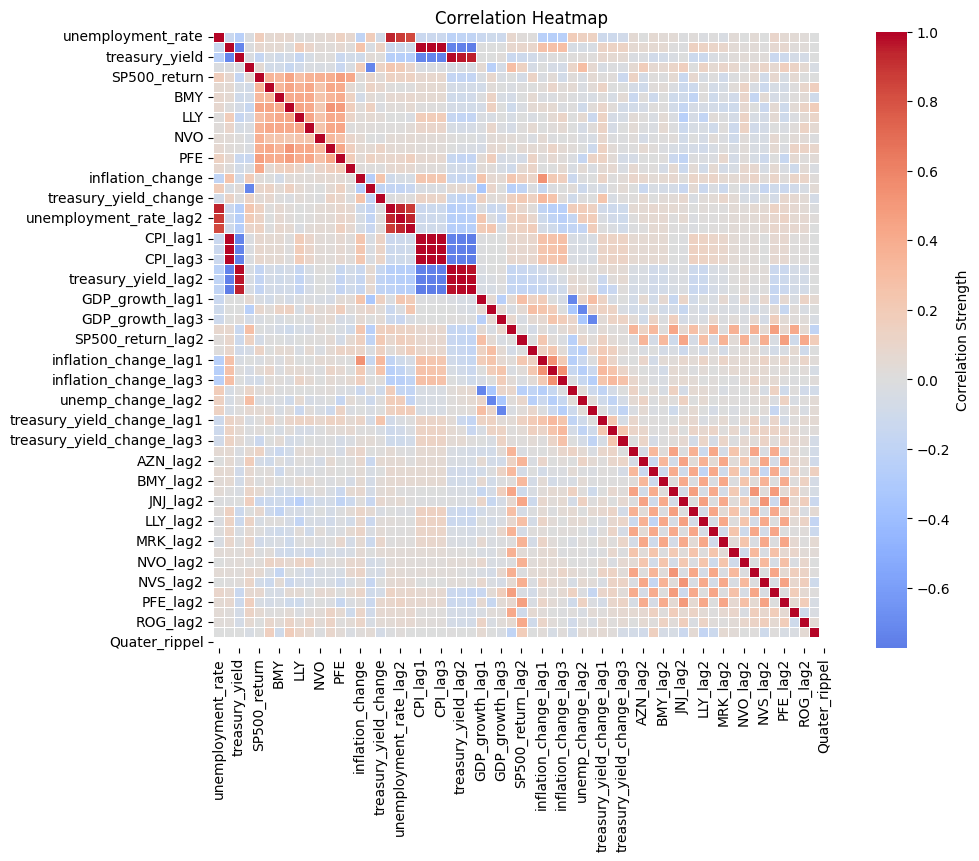

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Exclude the 'Date' column from correlation calculation
correlation_data = data.drop('Date', axis=1)

# Calculate the correlation matrix
correlation_matrix = correlation_data.corr()

# Create the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, linewidths=0.5,
            cbar_kws={'label': 'Correlation Strength'}, square=True, annot=False)
plt.title('Correlation Heatmap')
plt.show()

In [11]:
from statsmodels.tsa.stattools import adfuller

# Loop through each ticker
for ticker in tickers:
    # Extract the returns data for the current ticker
    returns = data[ticker]

    # Perform ADF test on the returns data
    result = adfuller(returns)

    # Extract the p-value from the test result
    p_value = result[1]

    # Check the p-value against a significance level (e.g., 0.05)
    if p_value < 0.05:
        print(f"The returns for {ticker} are stationary.")
    else:
        print(f"The returns for {ticker} are non-stationary.")


The returns for AZN are stationary.
The returns for BMY are stationary.
The returns for JNJ are stationary.
The returns for LLY are stationary.
The returns for MRK are stationary.
The returns for NVO are stationary.
The returns for NVS are stationary.
The returns for PFE are stationary.
The returns for ROG are stationary.


## ASTRAZENECA

In [12]:
azn_data = data[['Date', 'AZN']]

In [13]:
azn_data

,Date,AZN
0,2000-07-01,-8.064479
1,2000-08-01,6.578935
2,2000-09-01,15.363525
3,2000-10-01,-8.764862
4,2000-11-01,7.863717
...,...,...
270,2023-01-01,-3.584079
271,2023-02-01,-0.290649
272,2023-03-01,8.035329
273,2023-04-01,5.489119


In [14]:
import plotly.graph_objects as go

# Create a line plot of AZN returns using Plotly
fig = go.Figure(data=go.Scatter(x=azn_data['Date'], y=azn_data['AZN']))
fig.update_layout(
    title='AZN Returns over Time',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Returns'),
    showlegend=False,
    xaxis_tickangle=-45,
    hovermode='x',
    template='plotly_white'
)
fig.show()


In [15]:
azn_df = azn_data.copy()
azn_df['Date'] = pd.to_datetime(azn_df['Date'])

In [16]:
azn_df.set_index('Date', inplace=True)

In [17]:
from statsmodels.tsa.seasonal import STL
decomposition_azn = STL(azn_df['AZN']).fit()
trend_azn = decomposition_azn.trend
seasonal_azn = decomposition_azn.seasonal
residual_azn = decomposition_azn.resid

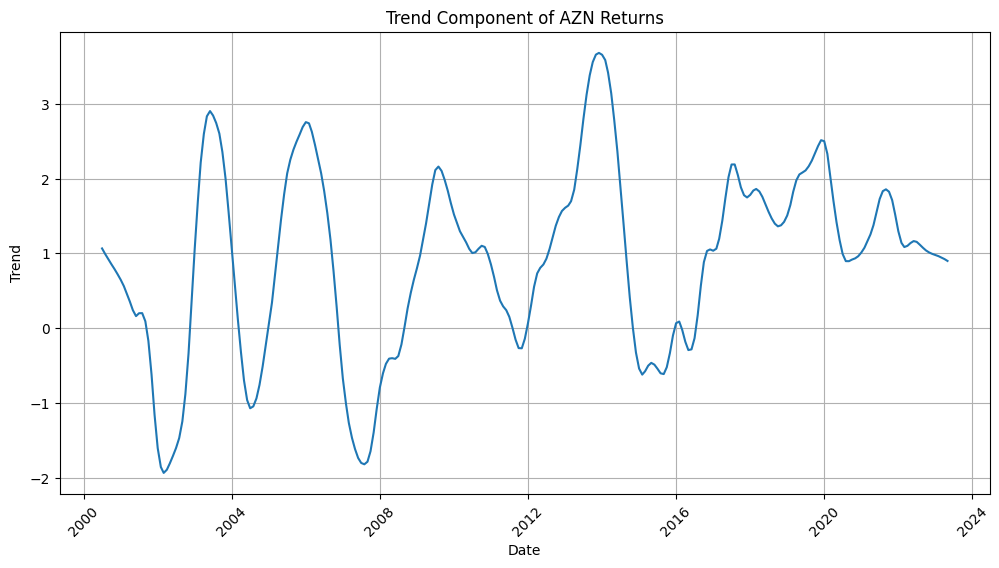

In [18]:
import matplotlib.pyplot as plt

# Plot the trend component
plt.figure(figsize=(12, 6))
plt.plot(trend_azn)
plt.title('Trend Component of AZN Returns')
plt.xlabel('Date')
plt.ylabel('Trend')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


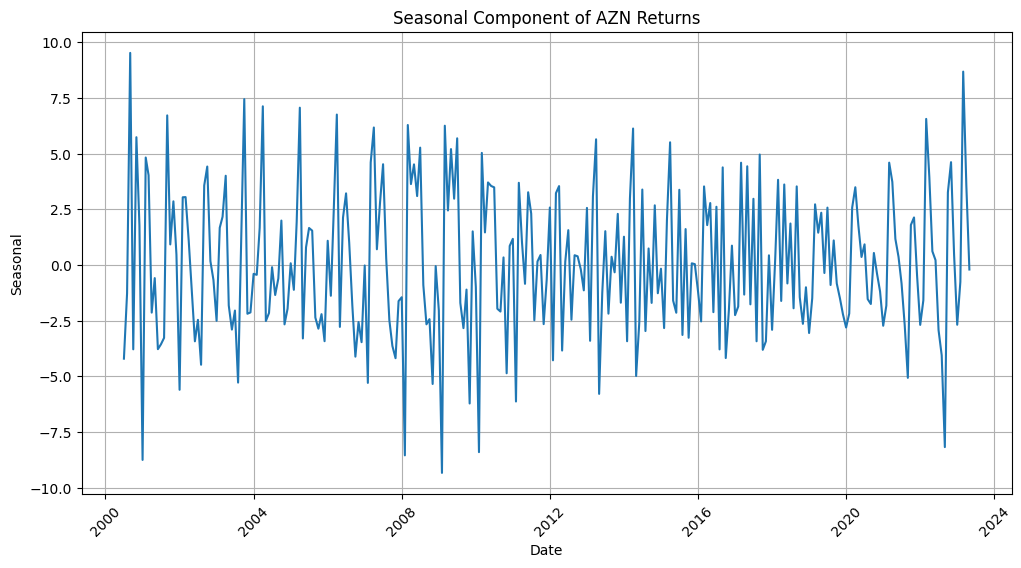

In [19]:
# Plot the seasonal component
plt.figure(figsize=(12, 6))
plt.plot(seasonal_azn)
plt.title('Seasonal Component of AZN Returns')
plt.xlabel('Date')
plt.ylabel('Seasonal')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

<Figure size 1200x600 with 0 Axes>

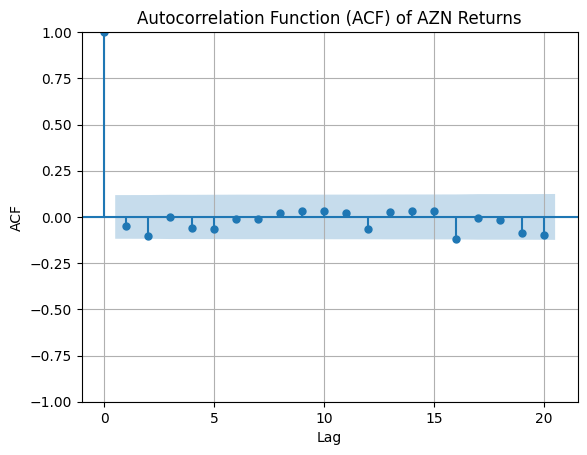

<Figure size 1200x600 with 0 Axes>

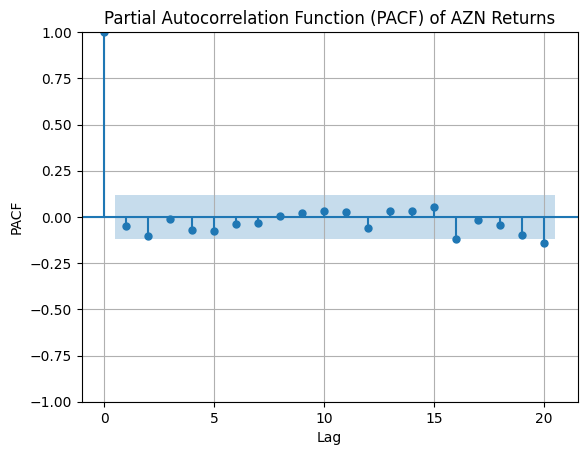

In [65]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Extract the 'AZN' returns
azn_returns = azn_data['AZN']

# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(azn_returns, lags=20, alpha=0.05)
plt.title('Autocorrelation Function (ACF) of AZN Returns')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.grid(True)
plt.show()

# Plot PACF
plt.figure(figsize=(12, 6))
plot_pacf(azn_returns, lags=20, alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF) of AZN Returns')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.grid(True)
plt.show()

In [27]:
import numpy as np

# Extract the lagged values from the data DataFrame
azn_lag1 = data['AZN_lag1']
azn_lag2 = data['AZN_lag2']

# Calculate the correlation coefficients
azn_corr_lag1 = np.corrcoef(azn_returns, azn_lag1)[0, 1]
azn_corr_lag2 = np.corrcoef(azn_returns, azn_lag2)[0, 1]

print(f"Correlation with lag1: {azn_corr_lag1}")
print(f"Correlation with lag2: {azn_corr_lag2}")

Correlation with lag1: -0.054405258153600894
Correlation with lag2: -0.09585821197810707


In [131]:
# Causality test

from statsmodels.tsa.stattools import grangercausalitytests

def granger_causality_test(data, target_col, feature_col, max_lag):
    results = grangercausalitytests(data[[target_col, feature_col]], max_lag, verbose=False)
    p_values = [round(results[i+1][0]['ssr_ftest'][1], 4) for i in range(max_lag)]
    return p_values

def find_optimal_lags(data, target_col, feature_cols, max_lag, significance_level=0.05):
    lag_p_values = {}
    for feature_col in feature_cols:
        p_values = granger_causality_test(data, target_col, feature_col, max_lag)
        significant_lags = [i + 1 for i, p_value in enumerate(p_values) if p_value < significance_level]
        lag_p_values[feature_col] = significant_lags
    return lag_p_values

In [21]:
# Significant lags

target_col = 'AZN'
feature_cols = ['AZN','AZN_lag1','AZN_lag2']

lag_p_values = find_optimal_lags(data, target_col, feature_cols, max_lag=3)
lag_p_values

{'AZN': [], 'AZN_lag1': [], 'AZN_lag2': []}

## Bristol-Myers Squibb Company

In [21]:
bmy_data = data[['Date', 'BMY']]

In [22]:
bmy_data

,Date,BMY
0,2000-07-01,-11.373392
1,2000-08-01,3.131245
2,2000-09-01,8.458631
3,2000-10-01,5.978226
4,2000-11-01,14.237843
...,...,...
270,2023-01-01,0.972908
271,2023-02-01,-4.328217
272,2023-03-01,0.507544
273,2023-04-01,-3.664707


In [33]:
import plotly.graph_objects as go

# Create a line plot of BMY returns using Plotly
fig = go.Figure(data=go.Scatter(x=bmy_data['Date'], y=bmy_data['BMY']))
fig.update_layout(
    title='BMY Returns over Time',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Returns'),
    showlegend=False,
    xaxis_tickangle=-45,
    hovermode='x',
    template='plotly_white'
)
fig.show()


In [23]:
bmy_df = bmy_data.copy()
bmy_df['Date'] = pd.to_datetime(bmy_df['Date'])

In [24]:
bmy_df.set_index('Date', inplace=True)

In [51]:
from statsmodels.tsa.seasonal import STL
decomposition_bmy = STL(bmy_df['BMY']).fit()
trend_bmy = decomposition_bmy.trend
seasonal_bmy = decomposition_bmy.seasonal
residual_bmy = decomposition_bmy.resid

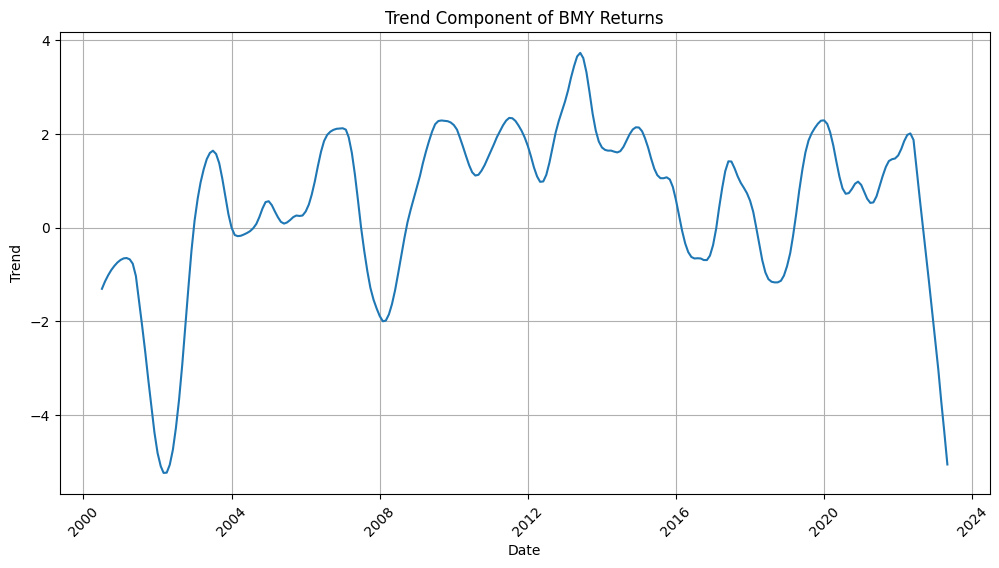

In [52]:
import matplotlib.pyplot as plt

# Plot the trend component
plt.figure(figsize=(12, 6))
plt.plot(trend_bmy)
plt.title('Trend Component of BMY Returns')
plt.xlabel('Date')
plt.ylabel('Trend')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

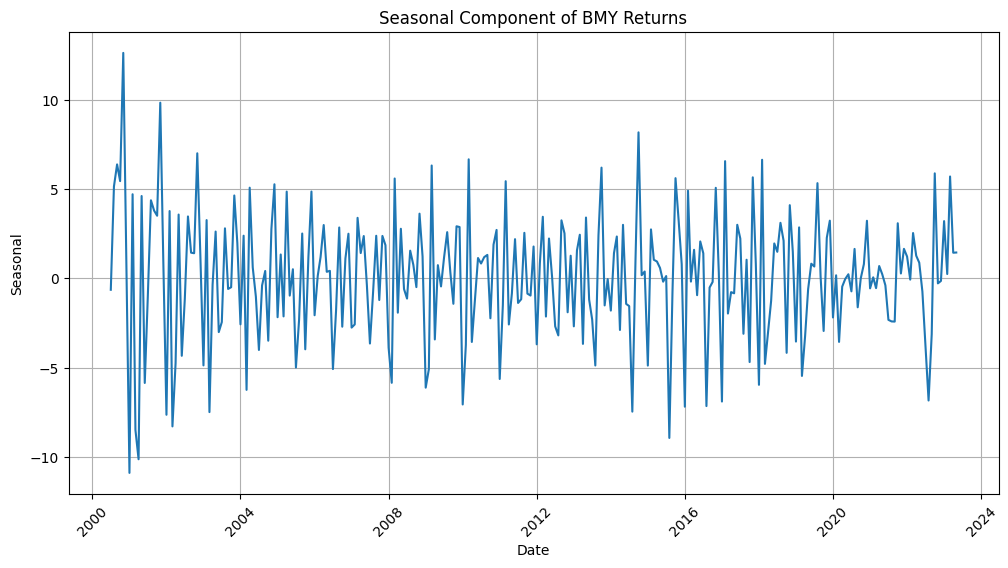

In [53]:
# Plot the seasonal component
plt.figure(figsize=(12, 6))
plt.plot(seasonal_bmy)
plt.title('Seasonal Component of BMY Returns')
plt.xlabel('Date')
plt.ylabel('Seasonal')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

<Figure size 1200x600 with 0 Axes>

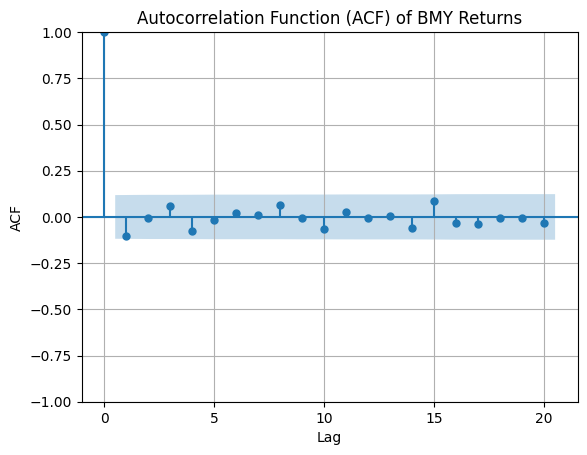

<Figure size 1200x600 with 0 Axes>

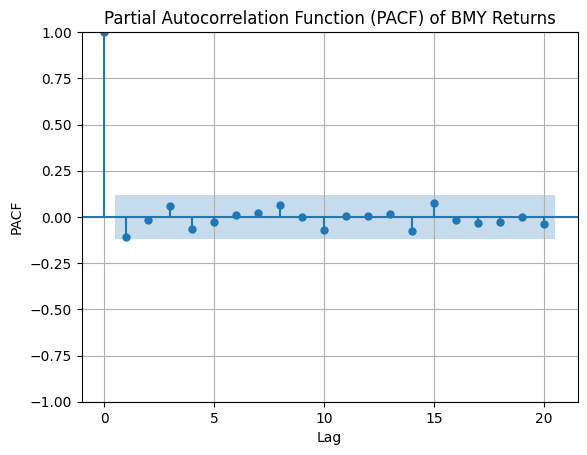

In [66]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Extract the 'BMY' returns
bmy_returns = bmy_data['BMY']

# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(bmy_returns, lags=20, alpha=0.05)
plt.title('Autocorrelation Function (ACF) of BMY Returns')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.grid(True)
plt.show()

# Plot PACF
plt.figure(figsize=(12, 6))
plot_pacf(bmy_returns, lags=20, alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF) of BMY Returns')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.grid(True)
plt.show()

In [30]:
import numpy as np

# Extract the lagged values from the data DataFrame
bmy_lag1 = data['BMY_lag1']
bmy_lag2 = data['BMY_lag2']

# Calculate the correlation coefficients
bmy_corr_lag1 = np.corrcoef(bmy_returns, bmy_lag1)[0, 1]
bmy_corr_lag2 = np.corrcoef(bmy_returns, bmy_lag2)[0, 1]

print(f"Correlation with lag1: {bmy_corr_lag1}")
print(f"Correlation with lag2: {bmy_corr_lag2}")

Correlation with lag1: -0.11038741382135514
Correlation with lag2: -0.007312072883462432


## JOHNSON & JOHNSON

In [31]:
jnj_data = data[['Date', 'JNJ']]

In [32]:
import plotly.graph_objects as go

# Create a line plot of JNJ returns using Plotly
fig = go.Figure(data=go.Scatter(x=jnj_data['Date'], y=jnj_data['JNJ']))
fig.update_layout(
    title='JNJ Returns over Time',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Returns'),
    showlegend=False,
    xaxis_tickangle=-45,
    hovermode='x',
    template='plotly_white'
)
fig.show()

In [33]:
jnj_df = jnj_data.copy()
jnj_df['Date'] = pd.to_datetime(jnj_df['Date'])

In [34]:
jnj_df.set_index('Date', inplace=True)

In [35]:
from statsmodels.tsa.seasonal import STL
decomposition_jnj = STL(jnj_df['JNJ']).fit()
trend_jnj = decomposition_jnj.trend
seasonal_jnj = decomposition_jnj.seasonal
residual_jnj = decomposition_jnj.resid

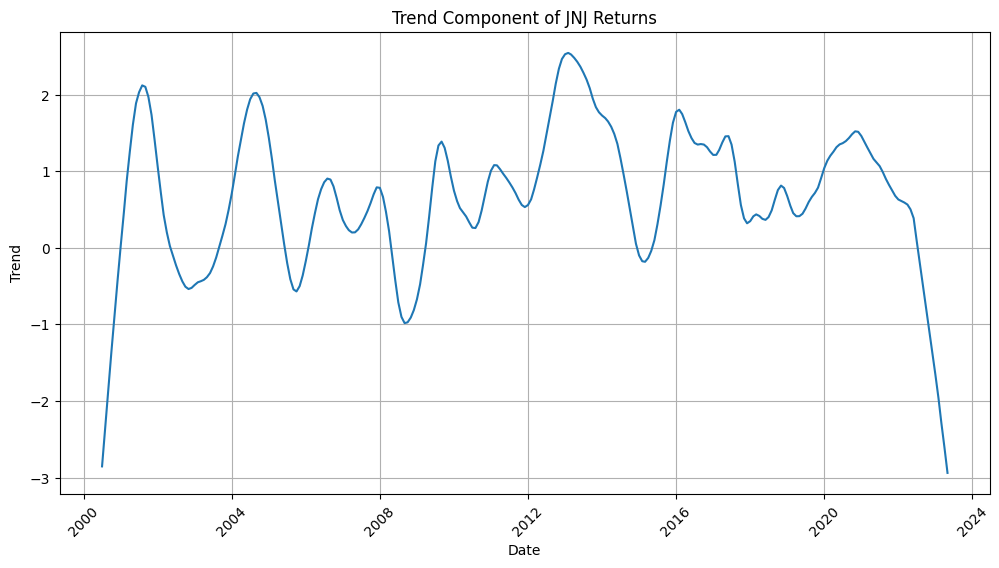

In [36]:
import matplotlib.pyplot as plt

# Plot the trend component
plt.figure(figsize=(12, 6))
plt.plot(trend_jnj)
plt.title('Trend Component of JNJ Returns')
plt.xlabel('Date')
plt.ylabel('Trend')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

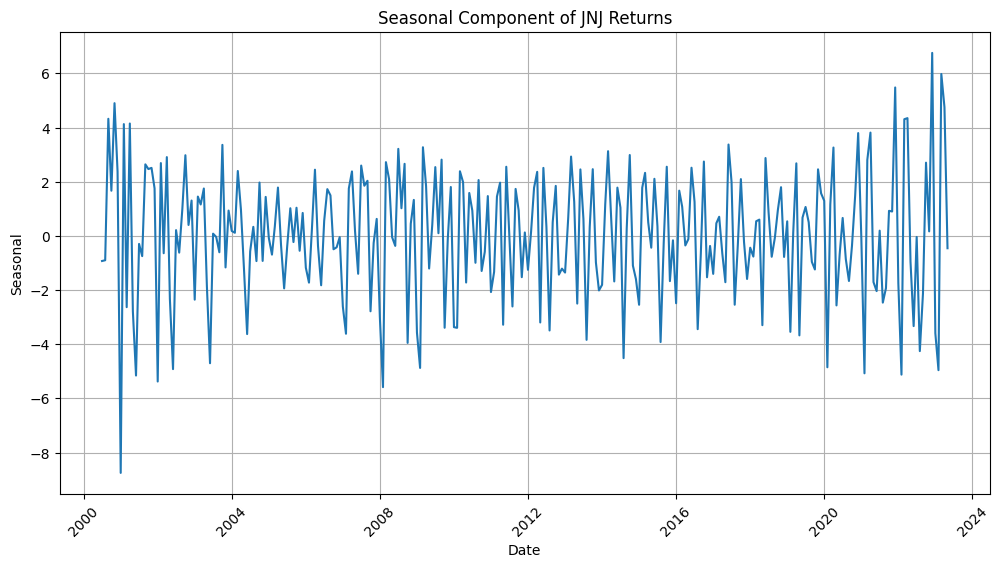

In [37]:
# Plot the seasonal component
plt.figure(figsize=(12, 6))
plt.plot(seasonal_jnj)
plt.title('Seasonal Component of JNJ Returns')
plt.xlabel('Date')
plt.ylabel('Seasonal')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

<Figure size 1200x600 with 0 Axes>

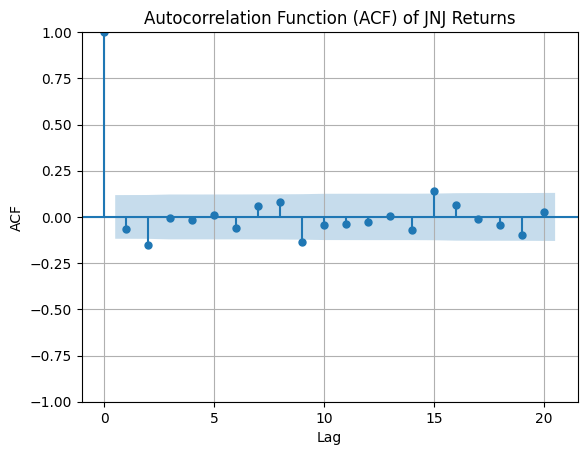

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



<Figure size 1200x600 with 0 Axes>

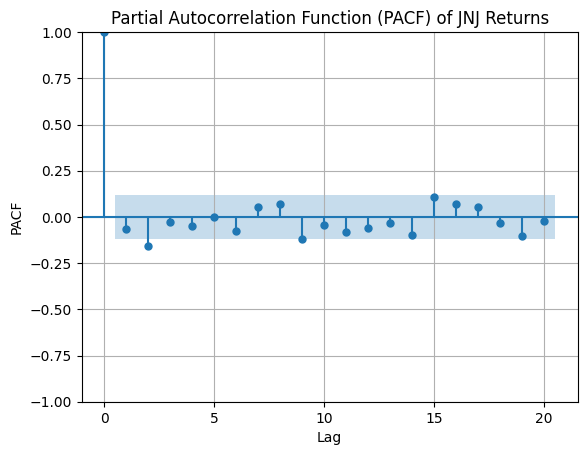

In [67]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Extract the 'JNJ' returns
jnj_returns = jnj_data['JNJ']

# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(jnj_returns, lags=20, alpha=0.05)
plt.title('Autocorrelation Function (ACF) of JNJ Returns')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.grid(True)
plt.show()

# Plot PACF
plt.figure(figsize=(12, 6))
plot_pacf(jnj_returns, lags=20, alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF) of JNJ Returns')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.grid(True)
plt.show()

In [40]:
import numpy as np

# Extract the lagged values from the data DataFrame
jnj_lag1 = data['JNJ_lag1']
jnj_lag2 = data['JNJ_lag2']

# Calculate the correlation coefficients
jnj_corr_lag1 = np.corrcoef(jnj_returns, jnj_lag1)[0, 1]
jnj_corr_lag2 = np.corrcoef(jnj_returns, jnj_lag2)[0, 1]

print(f"Correlation with lag1: {jnj_corr_lag1}")
print(f"Correlation with lag2: {jnj_corr_lag2}")

Correlation with lag1: -0.08544139870140777
Correlation with lag2: -0.16843841209772026


## Eli Lilly And Co

In [44]:
lly_data = data[['Date', 'LLY']]

In [45]:
import plotly.graph_objects as go

# Create a line plot of LLY returns using Plotly
fig = go.Figure(data=go.Scatter(x=lly_data['Date'], y=lly_data['LLY']))
fig.update_layout(
    title='LLY Returns over Time',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Returns'),
    showlegend=False,
    xaxis_tickangle=-45,
    hovermode='x',
    template='plotly_white'
)
fig.show()

In [46]:
lly_df = lly_data.copy()
lly_df['Date'] = pd.to_datetime(lly_df['Date'])

In [47]:
lly_df.set_index('Date', inplace=True)

In [48]:
from statsmodels.tsa.seasonal import STL
decomposition_lly = STL(lly_df['LLY']).fit()
trend_lly = decomposition_lly.trend
seasonal_lly = decomposition_lly.seasonal
residual_lly = decomposition_lly.resid

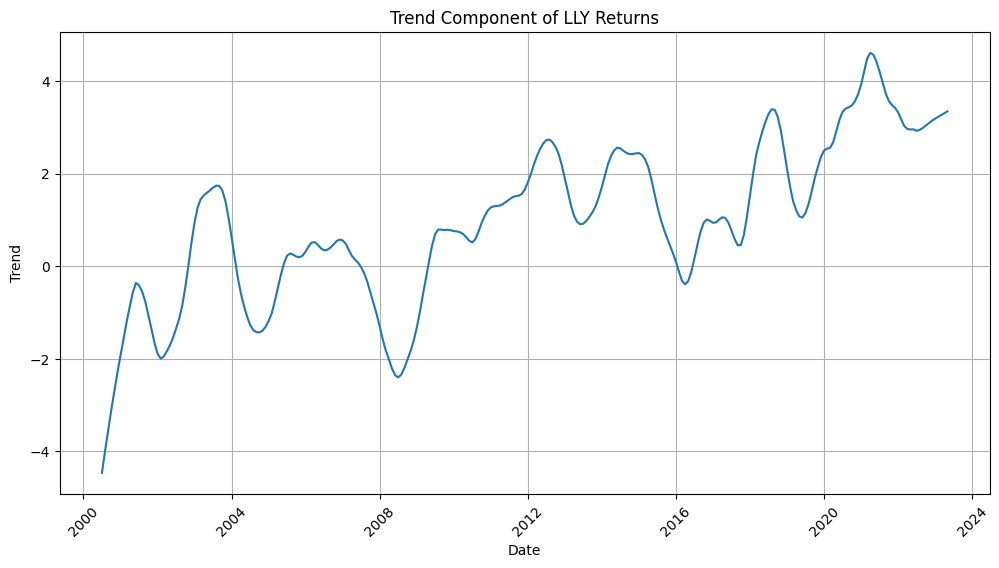

In [49]:
import matplotlib.pyplot as plt

# Plot the trend component
plt.figure(figsize=(12, 6))
plt.plot(trend_lly)
plt.title('Trend Component of LLY Returns')
plt.xlabel('Date')
plt.ylabel('Trend')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

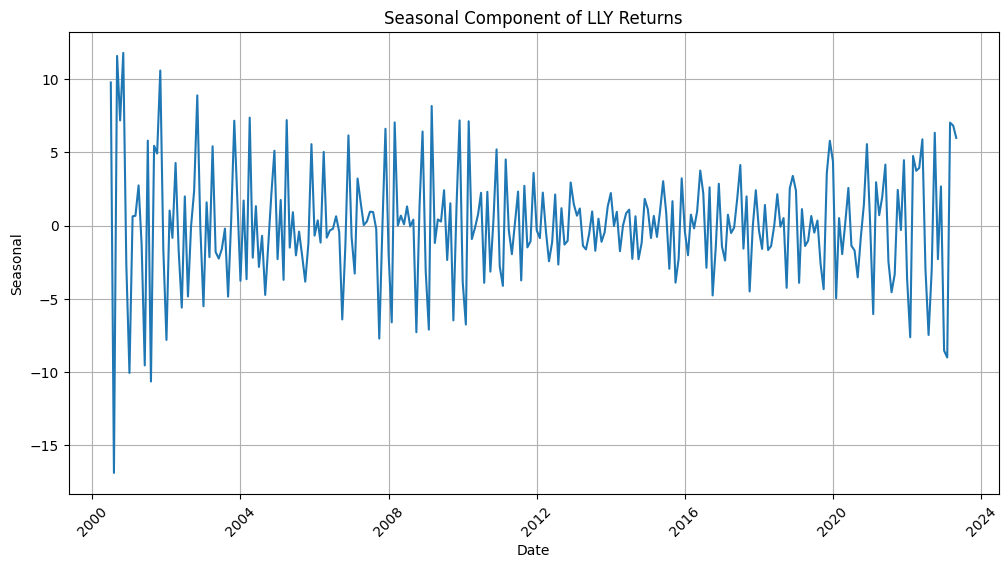

In [50]:
# Plot the seasonal component
plt.figure(figsize=(12, 6))
plt.plot(seasonal_lly)
plt.title('Seasonal Component of LLY Returns')
plt.xlabel('Date')
plt.ylabel('Seasonal')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

<Figure size 1200x600 with 0 Axes>

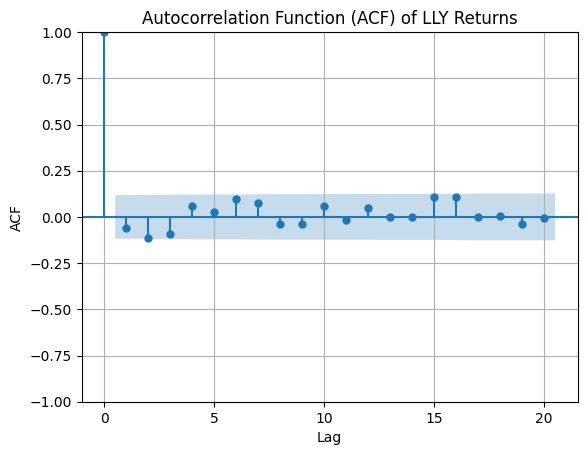

<Figure size 1200x600 with 0 Axes>

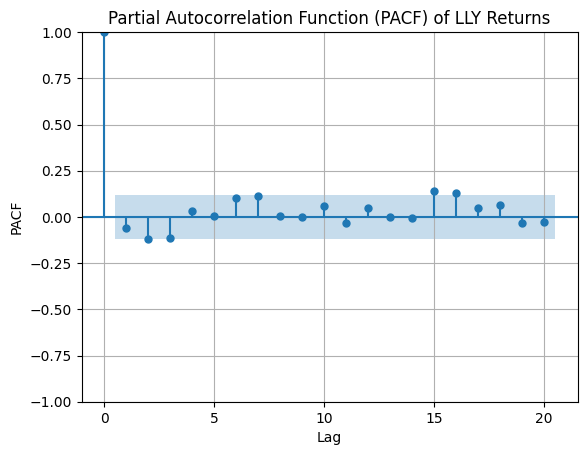

In [68]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Extract the 'AZN' returns
lly_returns = lly_data['LLY']

# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(lly_returns, lags=20, alpha=0.05)
plt.title('Autocorrelation Function (ACF) of LLY Returns')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.grid(True)
plt.show()

# Plot PACF
plt.figure(figsize=(12, 6))
plot_pacf(lly_returns, lags=20, alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF) of LLY Returns')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.grid(True)
plt.show()

In [56]:
import numpy as np

# Extract the lagged values from the data DataFrame
lly_lag1 = data['LLY_lag1']
lly_lag2 = data['LLY_lag2']

# Calculate the correlation coefficients
lly_corr_lag1 = np.corrcoef(lly_returns, lly_lag1)[0, 1]
lly_corr_lag2 = np.corrcoef(lly_returns, lly_lag2)[0, 1]

print(f"Correlation with lag1: {lly_corr_lag1}")
print(f"Correlation with lag2: {lly_corr_lag2}")

Correlation with lag1: -0.05243746792969043
Correlation with lag2: -0.18187412487576574


## Merck & Co Inc

In [57]:
mrk_data = data[['Date', 'MRK']]

In [58]:
import plotly.graph_objects as go

# Create a line plot of MRK returns using Plotly
fig = go.Figure(data=go.Scatter(x=mrk_data['Date'], y=mrk_data['MRK']))
fig.update_layout(
    title='MRK Returns over Time',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Returns'),
    showlegend=False,
    xaxis_tickangle=-45,
    hovermode='x',
    template='plotly_white'
)
fig.show()

In [59]:
mrk_df = mrk_data.copy()
mrk_df['Date'] = pd.to_datetime(mrk_df['Date'])

In [60]:
mrk_df.set_index('Date', inplace=True)

In [61]:
from statsmodels.tsa.seasonal import STL
decomposition_mrk = STL(mrk_df['MRK']).fit()
trend_mrk = decomposition_mrk.trend
seasonal_mrk = decomposition_mrk.seasonal
residual_mrk = decomposition_mrk.resid

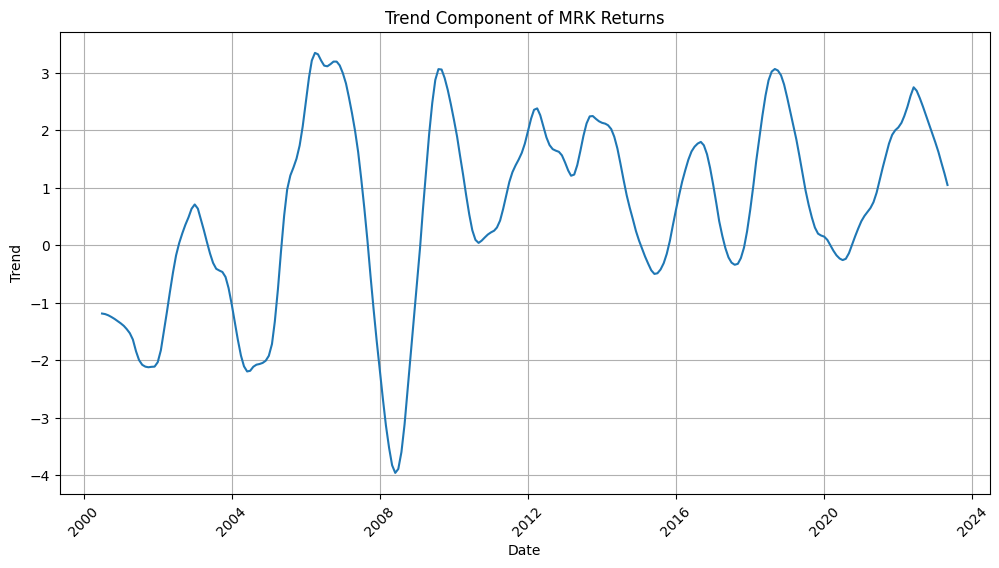

In [62]:
import matplotlib.pyplot as plt

# Plot the trend component
plt.figure(figsize=(12, 6))
plt.plot(trend_mrk)
plt.title('Trend Component of MRK Returns')
plt.xlabel('Date')
plt.ylabel('Trend')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

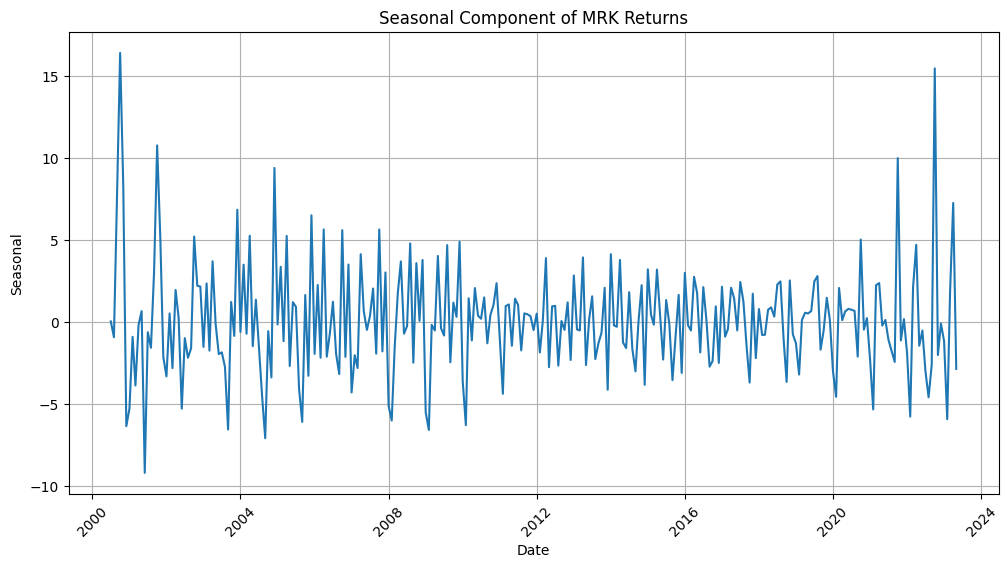

In [63]:
# Plot the seasonal component
plt.figure(figsize=(12, 6))
plt.plot(seasonal_mrk)
plt.title('Seasonal Component of MRK Returns')
plt.xlabel('Date')
plt.ylabel('Seasonal')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

<Figure size 1200x600 with 0 Axes>

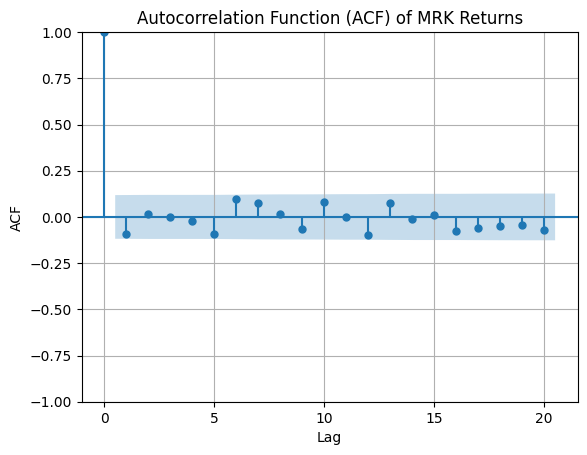

<Figure size 1200x600 with 0 Axes>

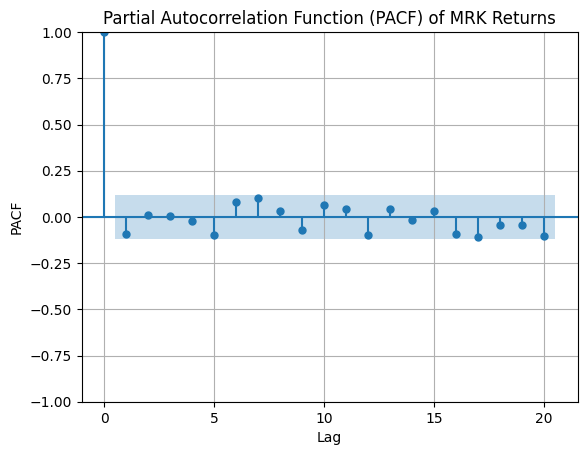

In [69]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Extract the 'MRK' returns
mrk_returns = mrk_data['MRK']

# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(mrk_returns, lags=20, alpha=0.05)
plt.title('Autocorrelation Function (ACF) of MRK Returns')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.grid(True)
plt.show()

# Plot PACF
plt.figure(figsize=(12, 6))
plot_pacf(mrk_returns, lags=20, alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF) of MRK Returns')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.grid(True)
plt.show()

In [70]:
import numpy as np

# Extract the lagged values from the data DataFrame
mrk_lag1 = data['MRK_lag1']
mrk_lag2 = data['MRK_lag2']

# Calculate the correlation coefficients
mrk_corr_lag1 = np.corrcoef(mrk_returns, mrk_lag1)[0, 1]
mrk_corr_lag2 = np.corrcoef(mrk_returns, mrk_lag2)[0, 1]

print(f"Correlation with lag1: {mrk_corr_lag1}")
print(f"Correlation with lag2: {mrk_corr_lag2}")

Correlation with lag1: -0.09409803762370071
Correlation with lag2: 0.01249592008364253


## Novo Nordisk A/S

In [71]:
nvo_data = data[['Date', 'NVO']]

In [72]:
import plotly.graph_objects as go

# Create a line plot of NVO returns using Plotly
fig = go.Figure(data=go.Scatter(x=nvo_data['Date'], y=nvo_data['NVO']))
fig.update_layout(
    title='NVO Returns over Time',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Returns'),
    showlegend=False,
    xaxis_tickangle=-45,
    hovermode='x',
    template='plotly_white'
)
fig.show()

In [73]:
nvo_df = nvo_data.copy()
nvo_df['Date'] = pd.to_datetime(nvo_df['Date'])

In [74]:
nvo_df.set_index('Date', inplace=True)

In [75]:
from statsmodels.tsa.seasonal import STL
decomposition_nvo = STL(nvo_df['NVO']).fit()
trend_nvo = decomposition_nvo.trend
seasonal_nvo = decomposition_nvo.seasonal
residual_nvo = decomposition_nvo.resid

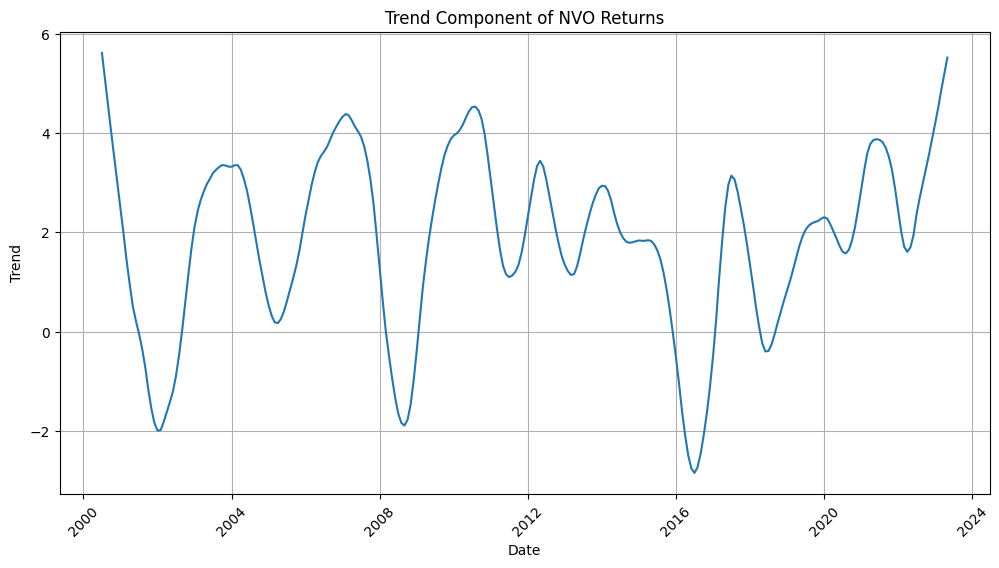

In [76]:
import matplotlib.pyplot as plt

# Plot the trend component
plt.figure(figsize=(12, 6))
plt.plot(trend_nvo)
plt.title('Trend Component of NVO Returns')
plt.xlabel('Date')
plt.ylabel('Trend')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

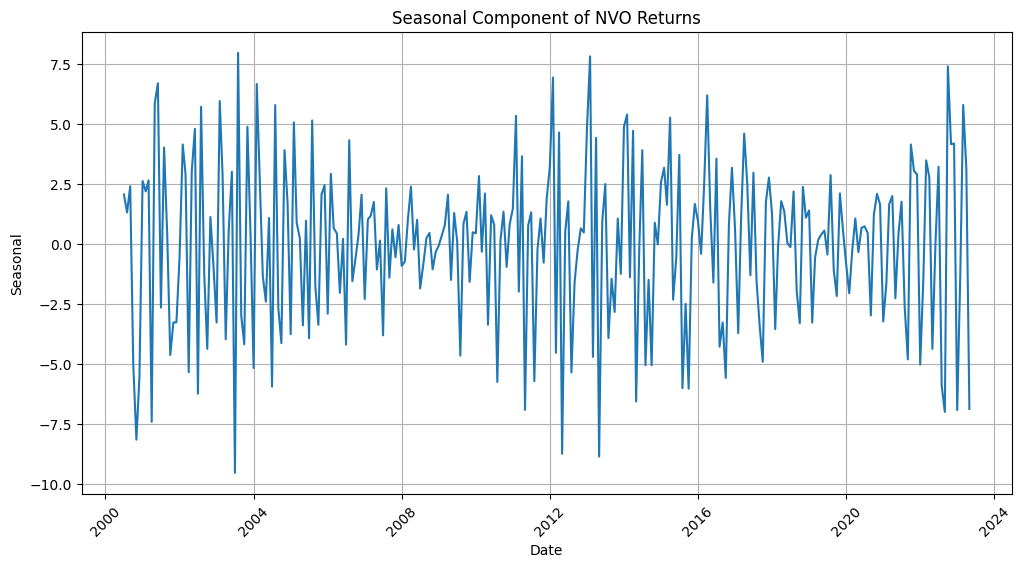

In [77]:
# Plot the seasonal component
plt.figure(figsize=(12, 6))
plt.plot(seasonal_nvo)
plt.title('Seasonal Component of NVO Returns')
plt.xlabel('Date')
plt.ylabel('Seasonal')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

<Figure size 1200x600 with 0 Axes>

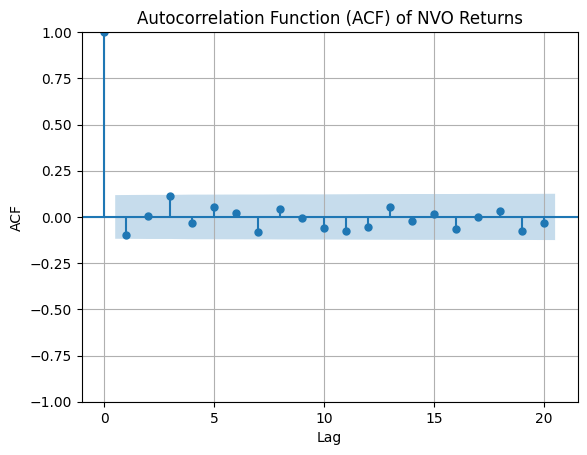

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



<Figure size 1200x600 with 0 Axes>

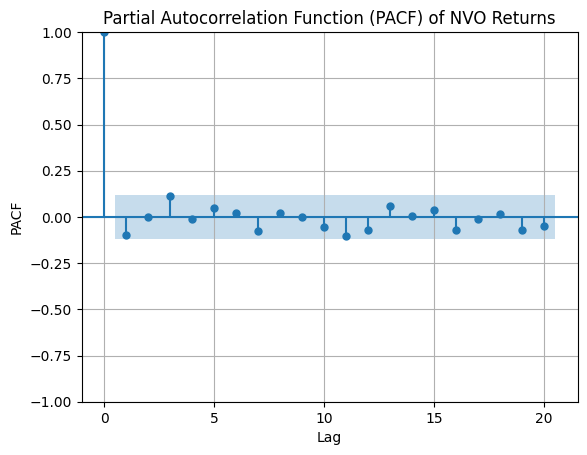

In [78]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Extract the 'NVO' returns
nvo_returns = nvo_data['NVO']

# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(nvo_returns, lags=20, alpha=0.05)
plt.title('Autocorrelation Function (ACF) of NVO Returns')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.grid(True)
plt.show()

# Plot PACF
plt.figure(figsize=(12, 6))
plot_pacf(nvo_returns, lags=20, alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF) of NVO Returns')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.grid(True)
plt.show()

In [79]:
import numpy as np

# Extract the lagged values from the data DataFrame
nvo_lag1 = data['NVO_lag1']
nvo_lag2 = data['NVO_lag2']

# Calculate the correlation coefficients
nvo_corr_lag1 = np.corrcoef(nvo_returns, nvo_lag1)[0, 1]
nvo_corr_lag2 = np.corrcoef(nvo_returns, nvo_lag2)[0, 1]

print(f"Correlation with lag1: {nvo_corr_lag1}")
print(f"Correlation with lag2: {nvo_corr_lag2}")

Correlation with lag1: -0.09773741361241117
Correlation with lag2: 0.023798757502183843


## Novartis

In [80]:
nvs_data = data[['Date', 'NVS']]

In [81]:
import plotly.graph_objects as go

# Create a line plot of NVS returns using Plotly
fig = go.Figure(data=go.Scatter(x=nvs_data['Date'], y=nvs_data['NVS']))
fig.update_layout(
    title='NVS Returns over Time',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Returns'),
    showlegend=False,
    xaxis_tickangle=-45,
    hovermode='x',
    template='plotly_white'
)
fig.show()

In [82]:
nvs_df = nvs_data.copy()
nvs_df['Date'] = pd.to_datetime(nvs_df['Date'])

In [83]:
nvs_df.set_index('Date', inplace=True)

In [84]:
from statsmodels.tsa.seasonal import STL
decomposition_nvs = STL(nvs_df['NVS']).fit()
trend_nvs = decomposition_nvs.trend
seasonal_nvs = decomposition_nvs.seasonal
residual_nvs = decomposition_nvs.resid

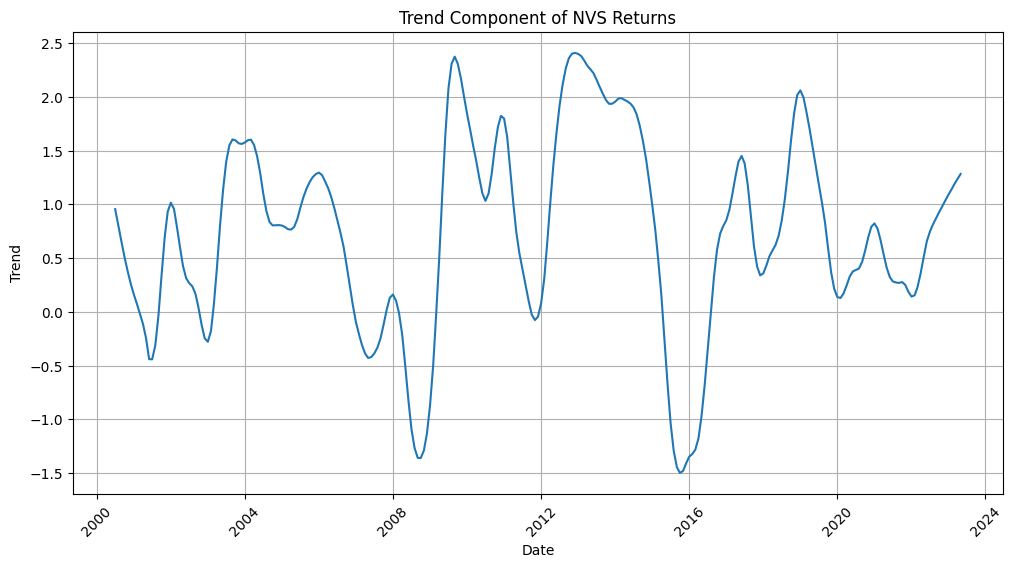

In [85]:
import matplotlib.pyplot as plt

# Plot the trend component
plt.figure(figsize=(12, 6))
plt.plot(trend_nvs)
plt.title('Trend Component of NVS Returns')
plt.xlabel('Date')
plt.ylabel('Trend')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

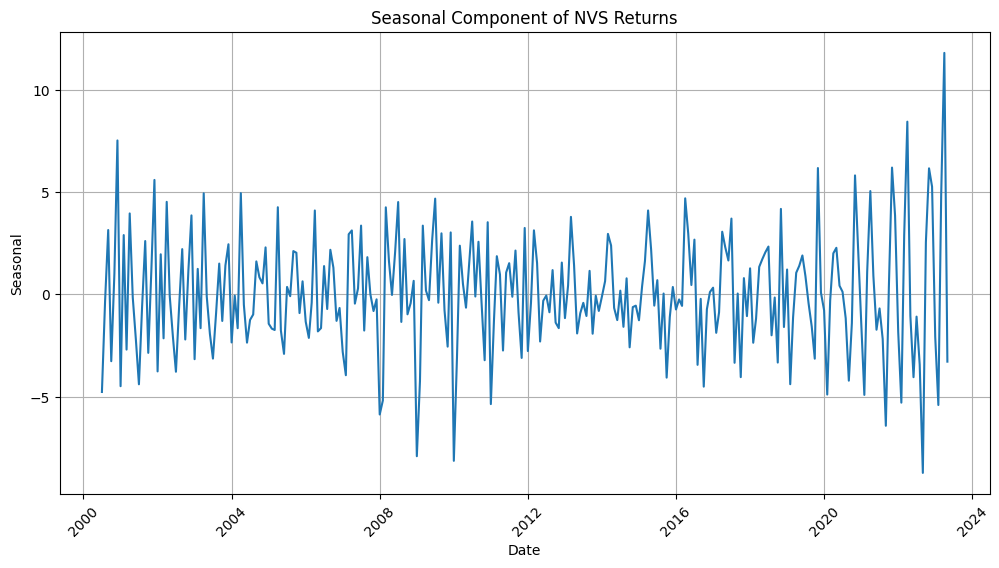

In [86]:
# Plot the seasonal component
plt.figure(figsize=(12, 6))
plt.plot(seasonal_nvs)
plt.title('Seasonal Component of NVS Returns')
plt.xlabel('Date')
plt.ylabel('Seasonal')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

<Figure size 1200x600 with 0 Axes>

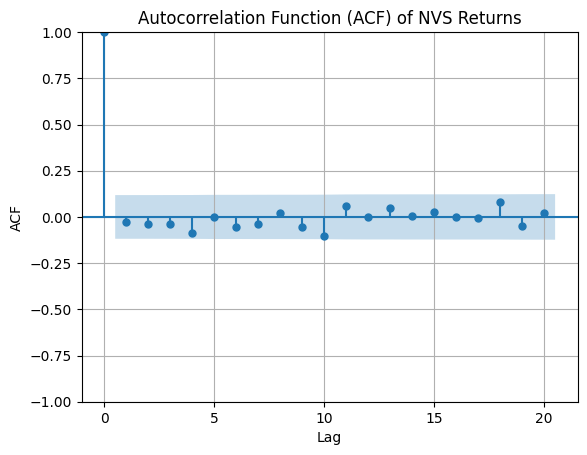

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



<Figure size 1200x600 with 0 Axes>

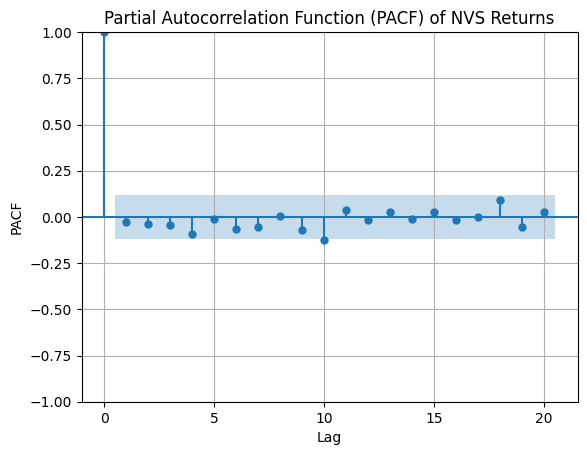

In [87]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Extract the 'NVS' returns
nvs_returns = nvs_data['NVS']

# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(nvs_returns, lags=20, alpha=0.05)
plt.title('Autocorrelation Function (ACF) of NVS Returns')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.grid(True)
plt.show()

# Plot PACF
plt.figure(figsize=(12, 6))
plot_pacf(nvs_returns, lags=20, alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF) of NVS Returns')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.grid(True)
plt.show()

In [88]:
import numpy as np

# Extract the lagged values from the data DataFrame
nvs_lag1 = data['NVS_lag1']
nvs_lag2 = data['NVS_lag2']

# Calculate the correlation coefficients
nvs_corr_lag1 = np.corrcoef(nvs_returns, nvs_lag1)[0, 1]
nvs_corr_lag2 = np.corrcoef(nvs_returns, nvs_lag2)[0, 1]

print(f"Correlation with lag1: {nvs_corr_lag1}")
print(f"Correlation with lag2: {nvs_corr_lag2}")

Correlation with lag1: -0.03131363420961486
Correlation with lag2: -0.0447440174159702


## Pfeizer

In [90]:
pfe_data = data[['Date', 'PFE']]

In [91]:
import plotly.graph_objects as go

# Create a line plot of PFE returns using Plotly
fig = go.Figure(data=go.Scatter(x=pfe_data['Date'], y=pfe_data['PFE']))
fig.update_layout(
    title='PFE Returns over Time',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Returns'),
    showlegend=False,
    xaxis_tickangle=-45,
    hovermode='x',
    template='plotly_white'
)
fig.show()

In [92]:
pfe_df = pfe_data.copy()
pfe_df['Date'] = pd.to_datetime(pfe_df['Date'])

In [93]:
pfe_df.set_index('Date', inplace=True)

In [94]:
from statsmodels.tsa.seasonal import STL
decomposition_pfe = STL(pfe_df['PFE']).fit()
trend_pfe = decomposition_pfe.trend
seasonal_pfe = decomposition_pfe.seasonal
residual_pfe = decomposition_pfe.resid

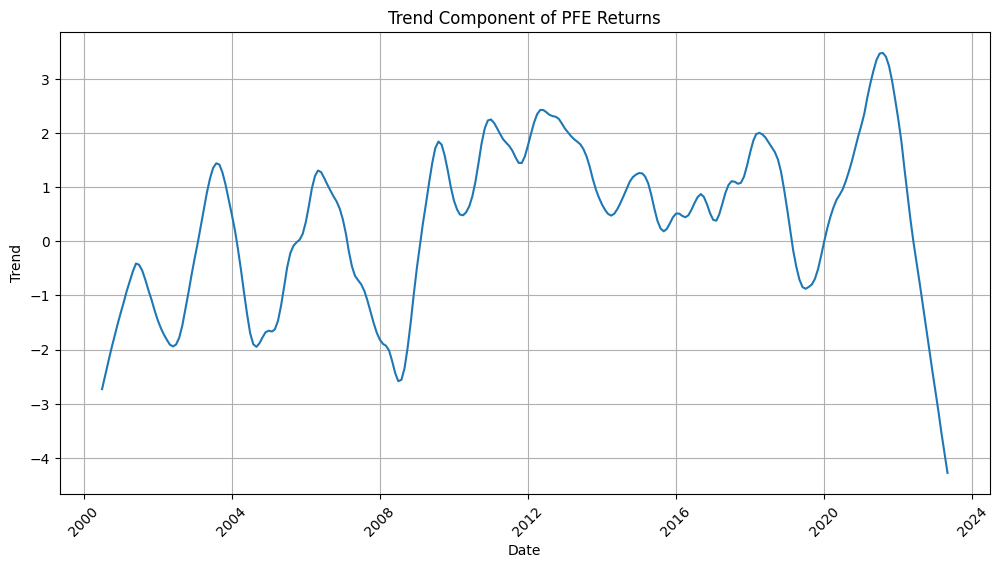

In [95]:
import matplotlib.pyplot as plt

# Plot the trend component
plt.figure(figsize=(12, 6))
plt.plot(trend_pfe)
plt.title('Trend Component of PFE Returns')
plt.xlabel('Date')
plt.ylabel('Trend')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

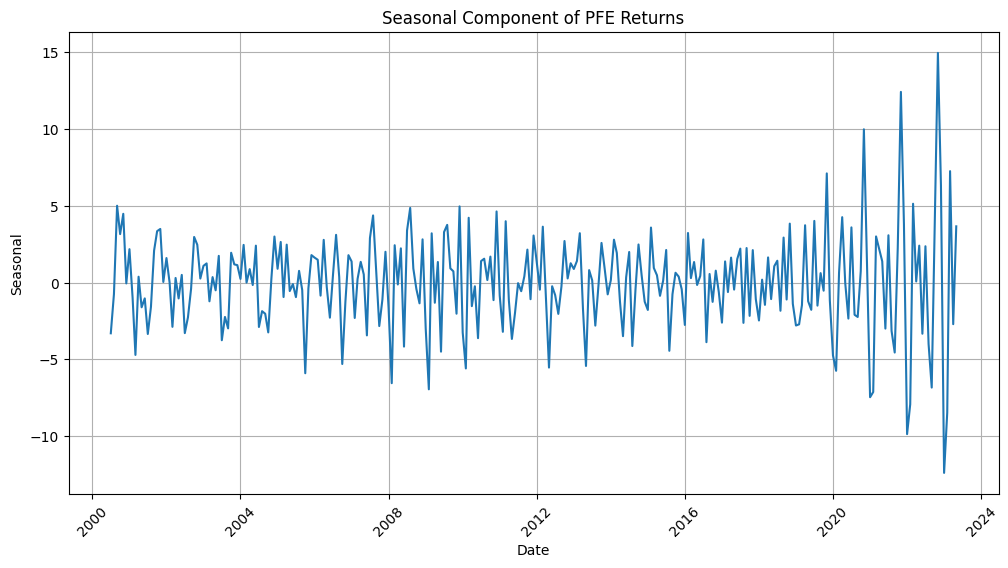

In [96]:
# Plot the seasonal component
plt.figure(figsize=(12, 6))
plt.plot(seasonal_pfe)
plt.title('Seasonal Component of PFE Returns')
plt.xlabel('Date')
plt.ylabel('Seasonal')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

<Figure size 1200x600 with 0 Axes>

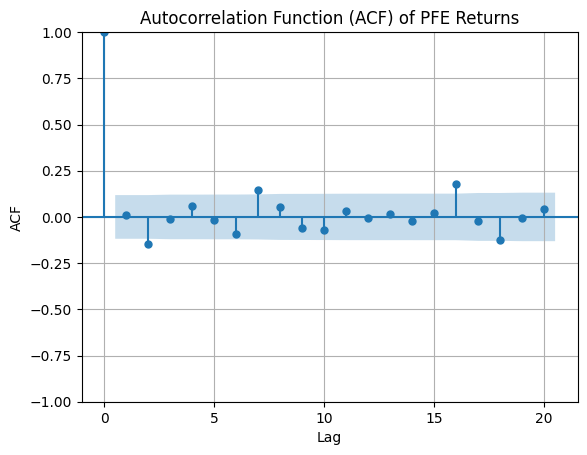

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



<Figure size 1200x600 with 0 Axes>

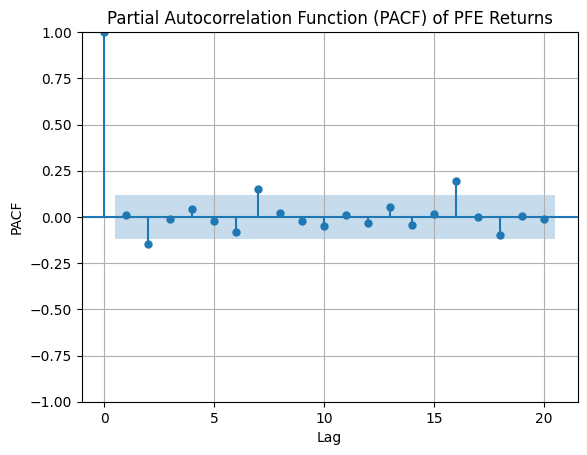

In [97]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Extract the 'PFE' returns
pfe_returns = pfe_data['PFE']

# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(pfe_returns, lags=20, alpha=0.05)
plt.title('Autocorrelation Function (ACF) of PFE Returns')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.grid(True)
plt.show()

# Plot PACF
plt.figure(figsize=(12, 6))
plot_pacf(pfe_returns, lags=20, alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF) of PFE Returns')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.grid(True)
plt.show()

In [98]:
import numpy as np

# Extract the lagged values from the data DataFrame
pfe_lag1 = data['PFE_lag1']
pfe_lag2 = data['PFE_lag2']

# Calculate the correlation coefficients
pfe_corr_lag1 = np.corrcoef(pfe_returns, pfe_lag1)[0, 1]
pfe_corr_lag2 = np.corrcoef(pfe_returns, pfe_lag2)[0, 1]

print(f"Correlation with lag1: {pfe_corr_lag1}")
print(f"Correlation with lag2: {pfe_corr_lag2}")

Correlation with lag1: -8.943136572916857e-05
Correlation with lag2: -0.14975452608059145


## Roche Holding AG

In [99]:
rog_data = data[['Date', 'ROG']]

In [100]:
import plotly.graph_objects as go

# Create a line plot of ROG returns using Plotly
fig = go.Figure(data=go.Scatter(x=rog_data['Date'], y=rog_data['ROG']))
fig.update_layout(
    title='ROG Returns over Time',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Returns'),
    showlegend=False,
    xaxis_tickangle=-45,
    hovermode='x',
    template='plotly_white'
)
fig.show()

In [101]:
rog_df = rog_data.copy()
rog_df['Date'] = pd.to_datetime(rog_df['Date'])

In [102]:
rog_df.set_index('Date', inplace=True)

In [103]:
from statsmodels.tsa.seasonal import STL
decomposition_rog = STL(rog_df['ROG']).fit()
trend_rog = decomposition_rog.trend
seasonal_rog = decomposition_rog.seasonal
residual_rog = decomposition_rog.resid

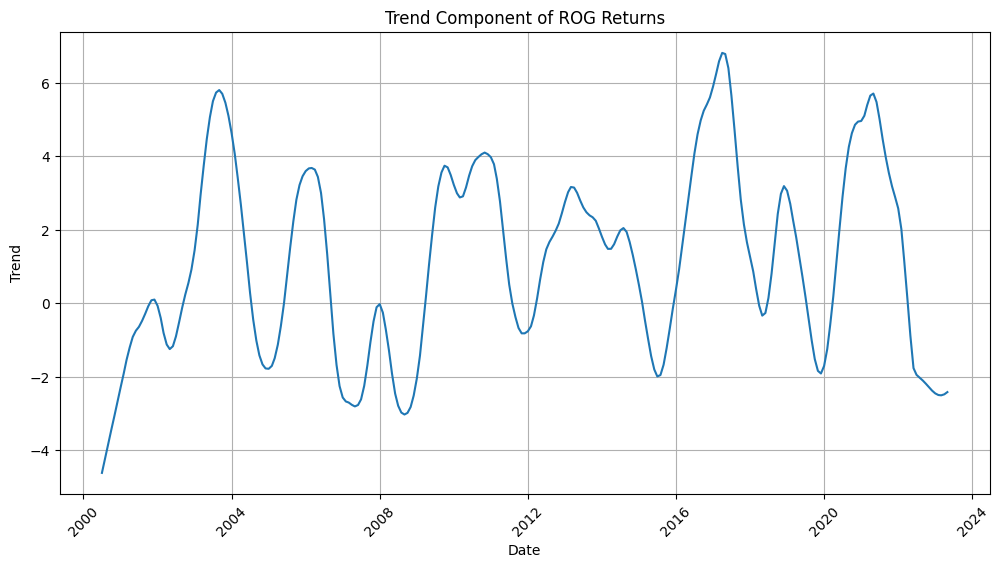

In [104]:
import matplotlib.pyplot as plt

# Plot the trend component
plt.figure(figsize=(12, 6))
plt.plot(trend_rog)
plt.title('Trend Component of ROG Returns')
plt.xlabel('Date')
plt.ylabel('Trend')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

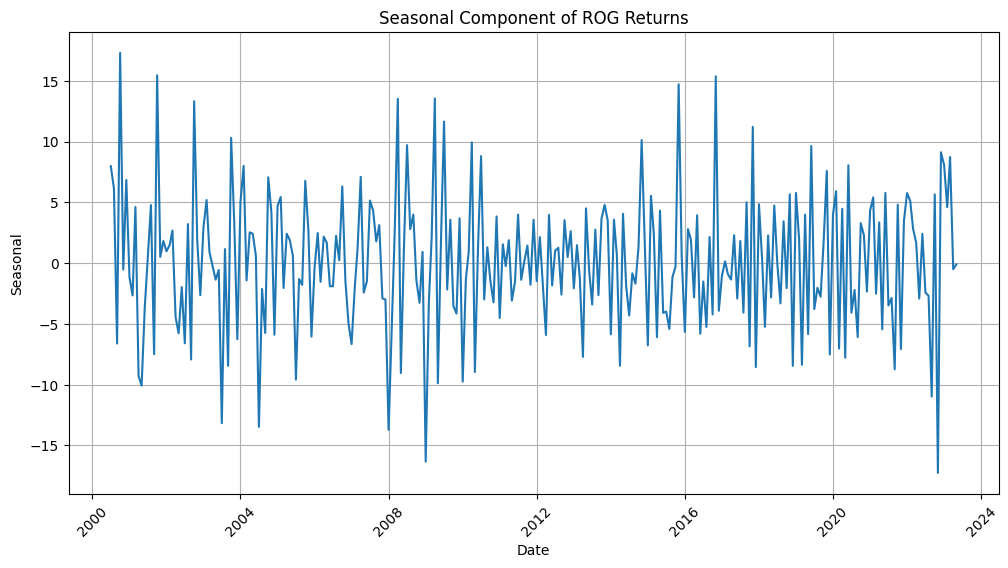

In [105]:
# Plot the seasonal component
plt.figure(figsize=(12, 6))
plt.plot(seasonal_rog)
plt.title('Seasonal Component of ROG Returns')
plt.xlabel('Date')
plt.ylabel('Seasonal')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

<Figure size 1200x600 with 0 Axes>

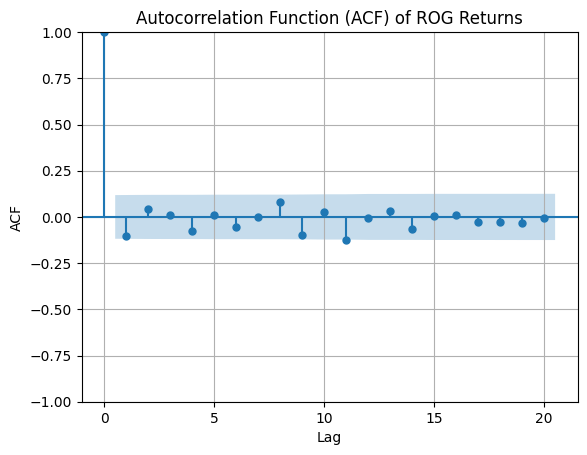

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



<Figure size 1200x600 with 0 Axes>

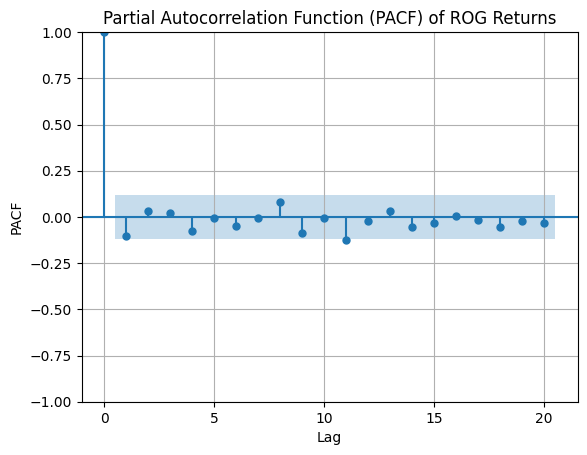

In [106]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Extract the 'ROG' returns
rog_returns = rog_data['ROG']

# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(rog_returns, lags=20, alpha=0.05)
plt.title('Autocorrelation Function (ACF) of ROG Returns')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.grid(True)
plt.show()

# Plot PACF
plt.figure(figsize=(12, 6))
plot_pacf(rog_returns, lags=20, alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF) of ROG Returns')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.grid(True)
plt.show()

In [107]:
import numpy as np

# Extract the lagged values from the data DataFrame
rog_lag1 = data['ROG_lag1']
rog_lag2 = data['ROG_lag2']

# Calculate the correlation coefficients
rog_corr_lag1 = np.corrcoef(rog_returns, rog_lag1)[0, 1]
rog_corr_lag2 = np.corrcoef(rog_returns, rog_lag2)[0, 1]

print(f"Correlation with lag1: {rog_corr_lag1}")
print(f"Correlation with lag2: {rog_corr_lag2}")

Correlation with lag1: -0.10074675457308431
Correlation with lag2: 0.03920525608739126


## For all TICKERS

In [15]:
import plotly.graph_objects as go

# Create a new figure
fig = go.Figure()

# Iterate through each ticker
for ticker in tickers:
    # Extract the returns data for the current ticker
    returns = data[ticker]

    # Add a line trace for the returns of the current ticker
    fig.add_trace(go.Scatter(x=data['Date'], y=returns, name=ticker))

# Configure the layout
fig.update_layout(
    title='Pharma Company Returns over Time',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Returns'),
    template='plotly_white'
)

# Show the figure
fig.show()

In [22]:
target_col = 'BMY'
feature_cols = ['BMY','BMY_lag1','BMY_lag2']

lag_p_values = find_optimal_lags(data, target_col, feature_cols, max_lag=3)
lag_p_values

{'BMY': [], 'BMY_lag1': [], 'BMY_lag2': []}

In [23]:
target_col = 'JNJ'
feature_cols = ['JNJ','JNJ_lag1','JNJ_lag2']

lag_p_values = find_optimal_lags(data, target_col, feature_cols, max_lag=3)
lag_p_values

{'JNJ': [], 'JNJ_lag1': [1], 'JNJ_lag2': []}

In [24]:
target_col = 'LLY'
feature_cols = ['LLY','LLY_lag1','LLY_lag2']

lag_p_values = find_optimal_lags(data, target_col, feature_cols, max_lag=3)
lag_p_values

{'LLY': [], 'LLY_lag1': [1], 'LLY_lag2': []}

In [25]:
target_col = 'MRK'
feature_cols = ['MRK','MRK_lag1','MRK_lag2']

lag_p_values = find_optimal_lags(data, target_col, feature_cols, max_lag=3)
lag_p_values

{'MRK': [], 'MRK_lag1': [], 'MRK_lag2': []}

In [26]:
target_col = 'NVS'
feature_cols = ['NVS','NVS_lag1','NVS_lag2']

lag_p_values = find_optimal_lags(data, target_col, feature_cols, max_lag=3)
lag_p_values

{'NVS': [], 'NVS_lag1': [], 'NVS_lag2': []}

In [27]:
target_col = 'NVO'
feature_cols = ['NVO','NVO_lag1','NVO_lag2']

lag_p_values = find_optimal_lags(data, target_col, feature_cols, max_lag=3)
lag_p_values

{'NVO': [], 'NVO_lag1': [], 'NVO_lag2': [1]}

In [28]:
target_col = 'PFE'
feature_cols = ['PFE','PFE_lag1','PFE_lag2']

lag_p_values = find_optimal_lags(data, target_col, feature_cols, max_lag=3)
lag_p_values

{'PFE': [], 'PFE_lag1': [1], 'PFE_lag2': []}

In [29]:
target_col = 'ROG'
feature_cols = ['ROG','ROG_lag1','ROG_lag2']

lag_p_values = find_optimal_lags(data, target_col, feature_cols, max_lag=3)
lag_p_values

{'ROG': [], 'ROG_lag1': [], 'ROG_lag2': []}

# ABBV: Special case

In [108]:
merged_df = pd.read_csv('merged_df.csv')

In [109]:
merged_df

,Date,ABBV,unemployment_rate,CPI,treasury_yield,GDP_growth,SP500_return,AZN,BMY,JNJ,LLY,MRK,NVO,NVS,PFE,ROG,inflation_change,unemp_change,treasury_yield_change
0,2013-03-01,10.455062,7.5,232.282,1.984211,0.397212,3.337507,14.582205,11.414669,7.978126,4.851792,3.440210,-7.714279,9.067089,5.443922,-0.188640,-0.655,-0.2,0.069449
1,2013-04-01,12.922975,7.6,231.797,1.957500,0.085246,2.374537,3.881563,-3.568848,4.538222,-2.482836,7.359867,11.497419,3.537347,0.727651,-10.457790,-0.485,0.1,-0.026711
2,2013-05-01,-6.438455,7.5,231.893,1.759091,-0.190605,2.361004,-1.290451,16.816781,-1.231989,-4.008663,-0.638313,-8.792401,-2.711502,-6.329562,8.513136,0.096,-0.1,-0.198409
3,2013-06-01,-3.162299,7.5,232.445,1.928182,0.620501,-1.853781,-7.707318,-2.868894,2.762464,-6.788137,-0.535372,-3.805087,-1.463219,3.722003,2.269287,0.552,0.0,0.169091
4,2013-07-01,10.014486,7.3,232.900,2.300000,0.210359,5.724173,7.230424,-3.244595,8.898141,8.122938,4.655361,9.001745,1.272809,4.355584,17.540151,0.455,-0.2,0.371818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,2023-01-01,-8.576205,3.4,300.536,3.616190,0.390254,6.776820,-3.584079,0.972908,-7.489384,-5.928822,-2.549213,2.541749,-0.110227,-13.817335,16.968326,1.546,-0.1,-0.274810
119,2023-02-01,5.152609,3.6,301.648,3.531500,-0.442183,-2.514271,-0.290649,-4.328217,-6.217115,-9.568502,-1.089288,1.592445,-7.172811,-7.286115,5.451681,1.112,0.2,-0.084690
120,2023-03-01,3.554254,3.5,301.808,3.746842,-0.442183,3.313488,8.035329,0.507544,1.862736,10.703390,0.141189,12.873250,9.367574,0.566924,11.025813,0.160,-0.1,0.215342
121,2023-04-01,-5.176628,3.4,302.918,3.663043,-0.442183,1.985238,5.489119,-3.664707,5.612908,15.269915,9.289214,5.836894,16.334413,-4.681371,-1.517467,1.110,-0.1,-0.083799


In [110]:
abbv_data = merged_df[['Date', 'ABBV']]

In [111]:
import plotly.graph_objects as go

# Create a line plot of ABBV returns using Plotly
fig = go.Figure(data=go.Scatter(x=abbv_data['Date'], y=abbv_data['ABBV']))
fig.update_layout(
    title='ABBV Returns over Time',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Returns'),
    showlegend=False,
    xaxis_tickangle=-45,
    hovermode='x',
    template='plotly_white'
)
fig.show()

In [112]:
abbv_df = abbv_data.copy()
abbv_df['Date'] = pd.to_datetime(abbv_df['Date'])

In [113]:
abbv_df.set_index('Date', inplace=True)

In [114]:
from statsmodels.tsa.seasonal import STL
decomposition_abbv = STL(abbv_df['ABBV']).fit()
trend_abbv = decomposition_abbv.trend
seasonal_abbv = decomposition_abbv.seasonal
residual_abbv = decomposition_abbv.resid

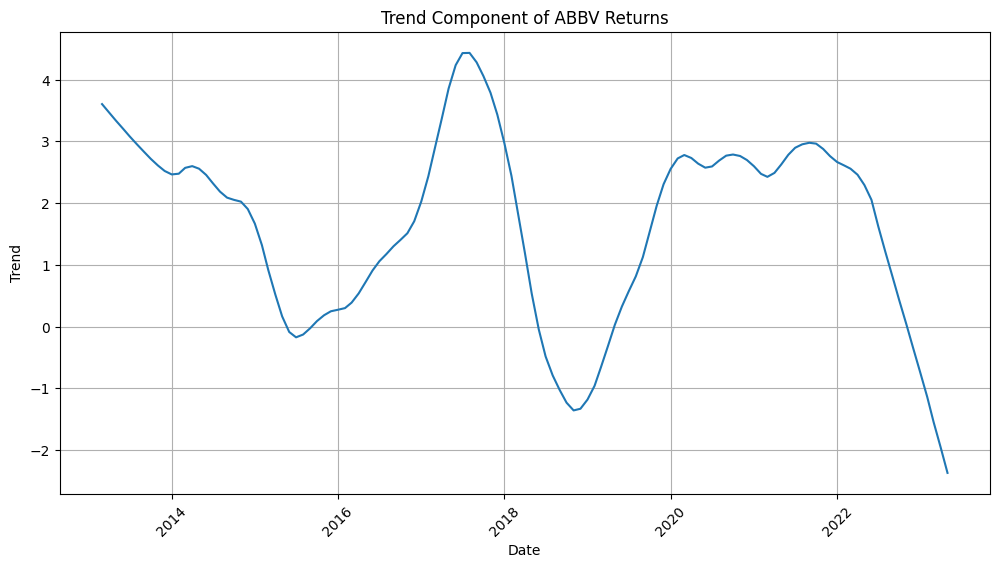

In [115]:
import matplotlib.pyplot as plt

# Plot the trend component
plt.figure(figsize=(12, 6))
plt.plot(trend_abbv)
plt.title('Trend Component of ABBV Returns')
plt.xlabel('Date')
plt.ylabel('Trend')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

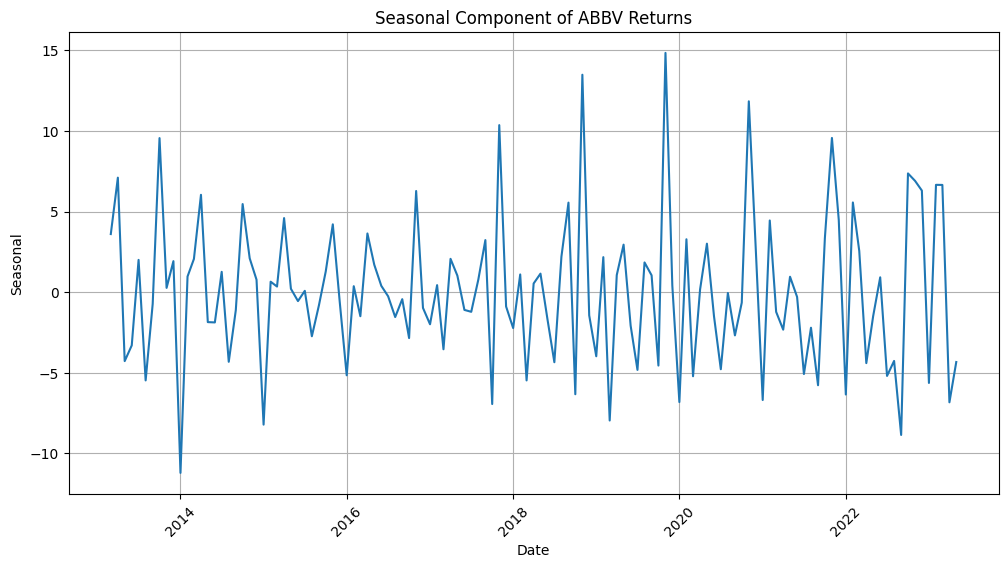

In [116]:
# Plot the seasonal component
plt.figure(figsize=(12, 6))
plt.plot(seasonal_abbv)
plt.title('Seasonal Component of ABBV Returns')
plt.xlabel('Date')
plt.ylabel('Seasonal')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

<Figure size 1200x600 with 0 Axes>

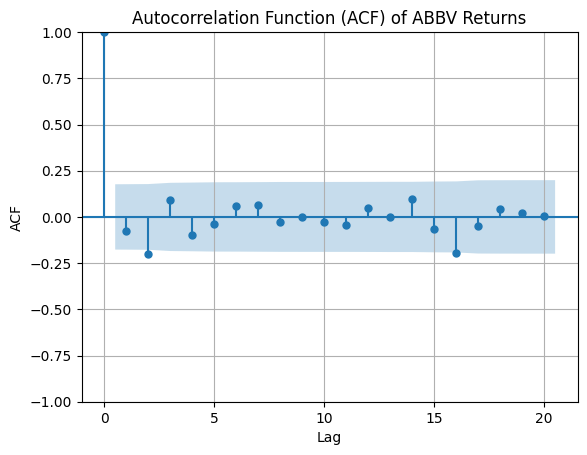

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



<Figure size 1200x600 with 0 Axes>

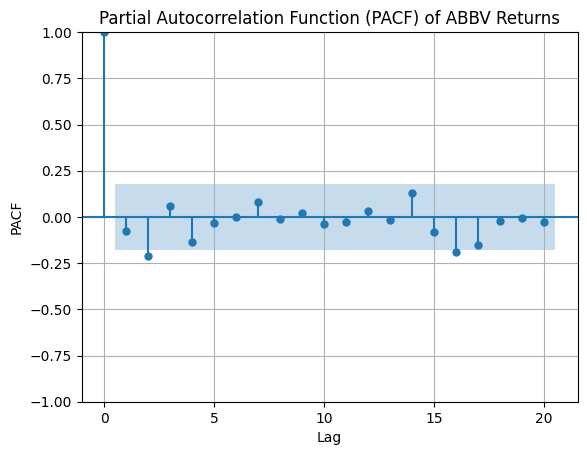

In [117]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Extract the 'ABBV' returns
abbv_returns = abbv_data['ABBV']

# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(abbv_returns, lags=20, alpha=0.05)
plt.title('Autocorrelation Function (ACF) of ABBV Returns')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.grid(True)
plt.show()

# Plot PACF
plt.figure(figsize=(12, 6))
plot_pacf(abbv_returns, lags=20, alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF) of ABBV Returns')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.grid(True)
plt.show()

In [120]:
def create_lags_returns(data, tickers, period):

    lagged_tickers = []  # List to store the names of lagged columns

    for tick in tickers:
        for i in period:
            lagged_column_name = f'{tick}_lag{i}'
            data[lagged_column_name] = data[tick].shift(i)
            lagged_tickers.append(lagged_column_name)

    data.dropna(inplace=True)
    data = data.reset_index(drop=True)

    return data, lagged_tickers

In [124]:
# Creating lagged variables
tickers = ['ABBV', 'AZN', 'BMY', 'JNJ', 'LLY', 'MRK', 'NVO', 'NVS', 'PFE','ROG']
covs = ['unemployment_rate', 'CPI', 'treasury_yield', 'GDP_growth', 'SP500_return', 'inflation_change', 'unemp_change', 'treasury_yield_change']
period_covs = [1, 2, 3]
period_returns = [1,2]

data, lagged_covs = create_lags_cov(merged_df, covs, period=period_covs)
data, lagged_tickers = create_lags_returns(merged_df, tickers, period= period_returns)

In [128]:
abbv_returns

0      10.455062
1      12.922975
2      -6.438455
3      -3.162299
4      10.014486
         ...    
118    -8.576205
119     5.152609
120     3.554254
121    -5.176628
122    -7.868480
Name: ABBV, Length: 123, dtype: float64

In [127]:
merged_df['ABBV']

5     -5.449157
6      4.975348
7      8.316584
8      0.900706
9      8.998948
         ...   
118   -8.576205
119    5.152609
120    3.554254
121   -5.176628
122   -7.868480
Name: ABBV, Length: 118, dtype: float64

In [126]:
merged_df['ABBV_lag1']

5      10.014486
6      -5.449157
7       4.975348
8       8.316584
9       0.900706
         ...    
118     0.266786
119    -8.576205
120     5.152609
121     3.554254
122    -5.176628
Name: ABBV_lag1, Length: 118, dtype: float64

In [129]:
import numpy as np

# Extract the lagged values from the data DataFrame
abbv_lag1 = merged_df['ABBV_lag1']
abbv_lag2 = merged_df['ABBV_lag2']

# Calculate the correlation coefficients
abbv_corr_lag1 = np.corrcoef(merged_df['ABBV'], abbv_lag1)[0, 1]
abbv_corr_lag2 = np.corrcoef(merged_df['ABBV'], abbv_lag2)[0, 1]

print(f"Correlation with lag1: {abbv_corr_lag1}")
print(f"Correlation with lag2: {abbv_corr_lag2}")

Correlation with lag1: -0.08310323931627184
Correlation with lag2: -0.18070067290463113


In [132]:
target_col = 'ABBV'
feature_cols = ['ABBV','ABBV_lag1','ABBV_lag2']

lag_p_values = find_optimal_lags(merged_df, target_col, feature_cols, max_lag=3)
lag_p_values

{'ABBV': [], 'ABBV_lag1': [1], 'ABBV_lag2': []}